# Anomaly Detection 
---

This notebook implements the anomaly detection methods presented in the thesis. We propose two setups: 
1. **Residual based anomaly detection**
2. **Prediction interval-based anomaly detection**

Read more about the respective methods further down in the notebook. 

In [1]:
import os, sys
ROOT_PATH = os.path.abspath(".").split("src")[0]
module_path = os.path.abspath(os.path.join(ROOT_PATH + "src/utils/"))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pickle
import math
import numpy as np
import pandas as pd
import keras
from scipy import stats as scstats
from sklearn.linear_model import LinearRegression
from datetime import datetime

# plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import seaborn as sns

# custom scripts
import functions as f
import dl_functions as dlf
from data_preprocessor import DataPreprocessor

SEED=100; np.random.seed(SEED)

In [2]:
c, p = f.color_palette()
sns.set(context='paper', style='whitegrid', palette=np.array(p))
plt.style.use('file://' + ROOT_PATH + "src/utils/plotparams.rc")

---

## [1] Load datasets

First, we extract the datasets we will use to demonstrate the anomaly detection schemes. We use the `DataPreprocessor` module for this, found in `.../src/utils/data_preprocessor.py`. We only extract two-day intervals from three separate months: 
- 2nd to 4th of April 2018
- 7th to 9th of July 2018
- 13th to 15th of December 2018

---

In [3]:
# read metadata
scaling_stats, target_tags, feature_tags=f.load_metadata()
all_tags = np.append(target_tags, feature_tags)
target_stds = scaling_stats.loc[target_tags,"Std"].values
target_means = scaling_stats.loc[target_tags,"Mean"].values

In [4]:
dp = DataPreprocessor(verbose=1)

# April 2018
start_april = datetime(2018,4,2,9)
end_april = datetime(2018,4,3,19)
df_april = dp.read_preprocess_data(from_date = start_april, to_date = end_april)

# July 2018
start_july = datetime(2018,7,8,7)
end_july = datetime(2018,7,9,0)
df_july = dp.read_preprocess_data(from_date = start_july, to_date = end_july)

# December 2018
start_dec = datetime(2018,12,13,5)
end_dec = datetime(2018,12,14,13)
df_dec = dp.read_preprocess_data(from_date = start_dec, to_date = end_dec)

# Split into features and targets 
x_april, y_april = f.split_dataset(df_april.values, delay=1)
x_july, y_july = f.split_dataset(df_july.values, delay=1)
x_dec, y_dec = f.split_dataset(df_dec.values, delay=1)

print(df_april.shape, df_july.shape, df_dec.shape)

Extracting data for 9 tags from 2018-04-02 09:00:00 to 2018-04-03 19:00:00
Extracting data for 9 tags from 2018-07-08 07:00:00 to 2018-07-09 00:00:00
Extracting data for 9 tags from 2018-12-13 05:00:00 to 2018-12-14 13:00:00
(2040, 9) (1020, 9) (1920, 9)


In [16]:
def plot_dataset(df, from_date, to_date, signal=1, x_fmt=None, y_fmt=None, delta=1): 
    df_unsc = df * dp.scaling_stats["Std"] + dp.scaling_stats["Mean"]
    
    fig, ax = plt.subplots(1,1, figsize=(15,3), dpi=200)
    if x_fmt: x_fmt(ax)
    
    ax.plot(df_unsc[from_date:to_date:delta].iloc[:,signal], lw=1.5)
    if y_fmt: y_fmt(ax)
        
    fig.show()

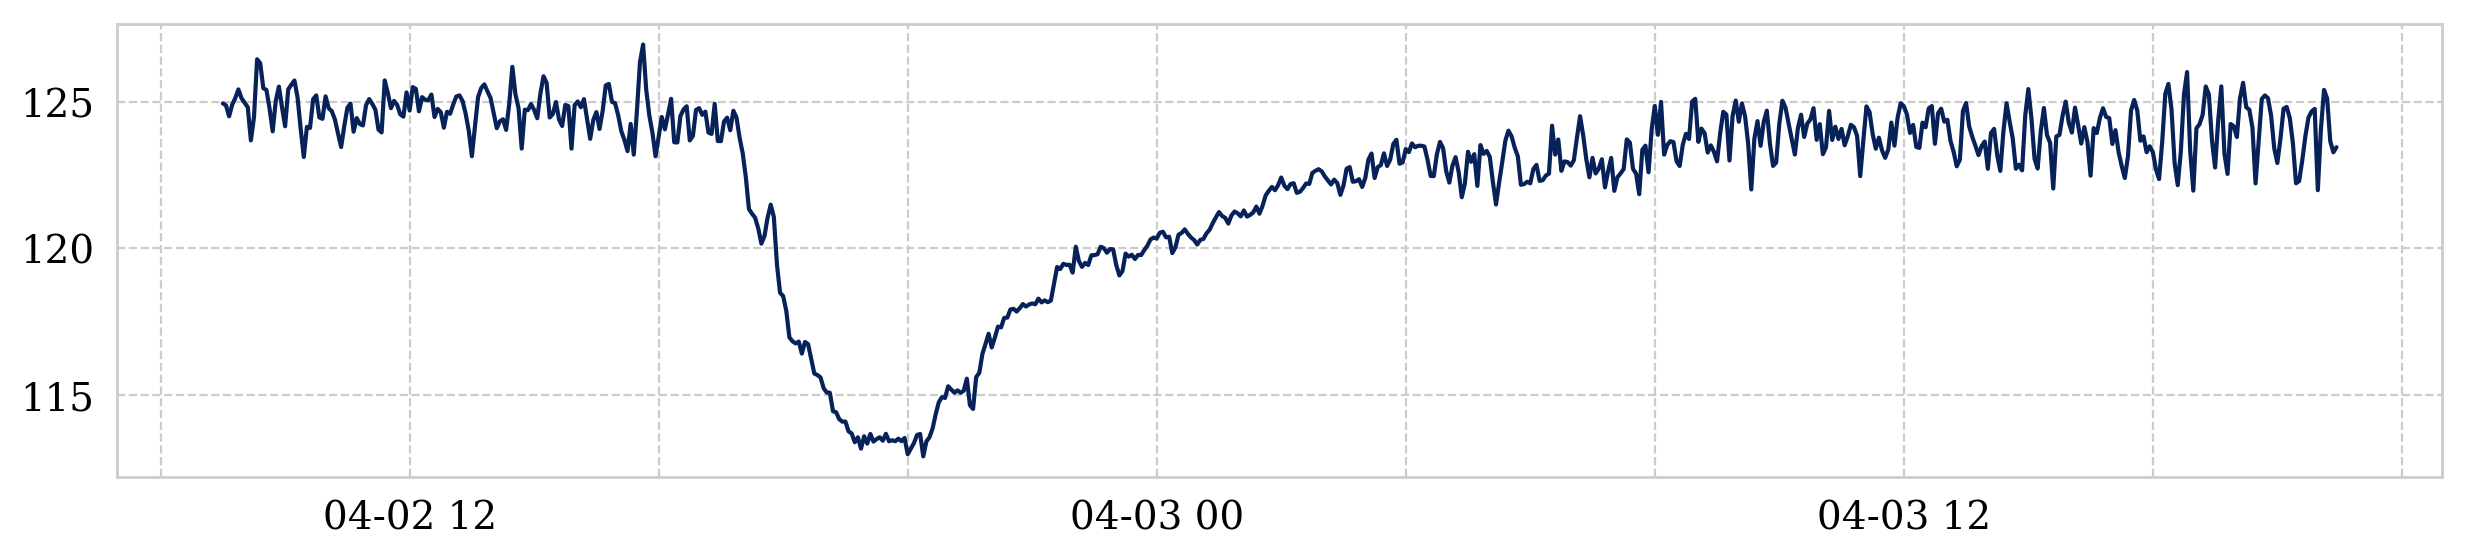

In [17]:
# Plot April
def x_fmt(ax):
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m %H:%M'))

def y_fmt(ax):
    # yticks
    #[label.set_visible(False) for label in ax.get_yticklabels()[::2]]
    
    # xticks
    [label.set_visible(False) for label in ax.get_xticklabels()]
    [label.set_visible(True) for label in ax.get_xticklabels()[1::3]]

plot_dataset(df_april, datetime(2018,4,2), datetime(2018,4,4), 
             signal=1, x_fmt=y_fmt, y_fmt=y_fmt, delta=3)

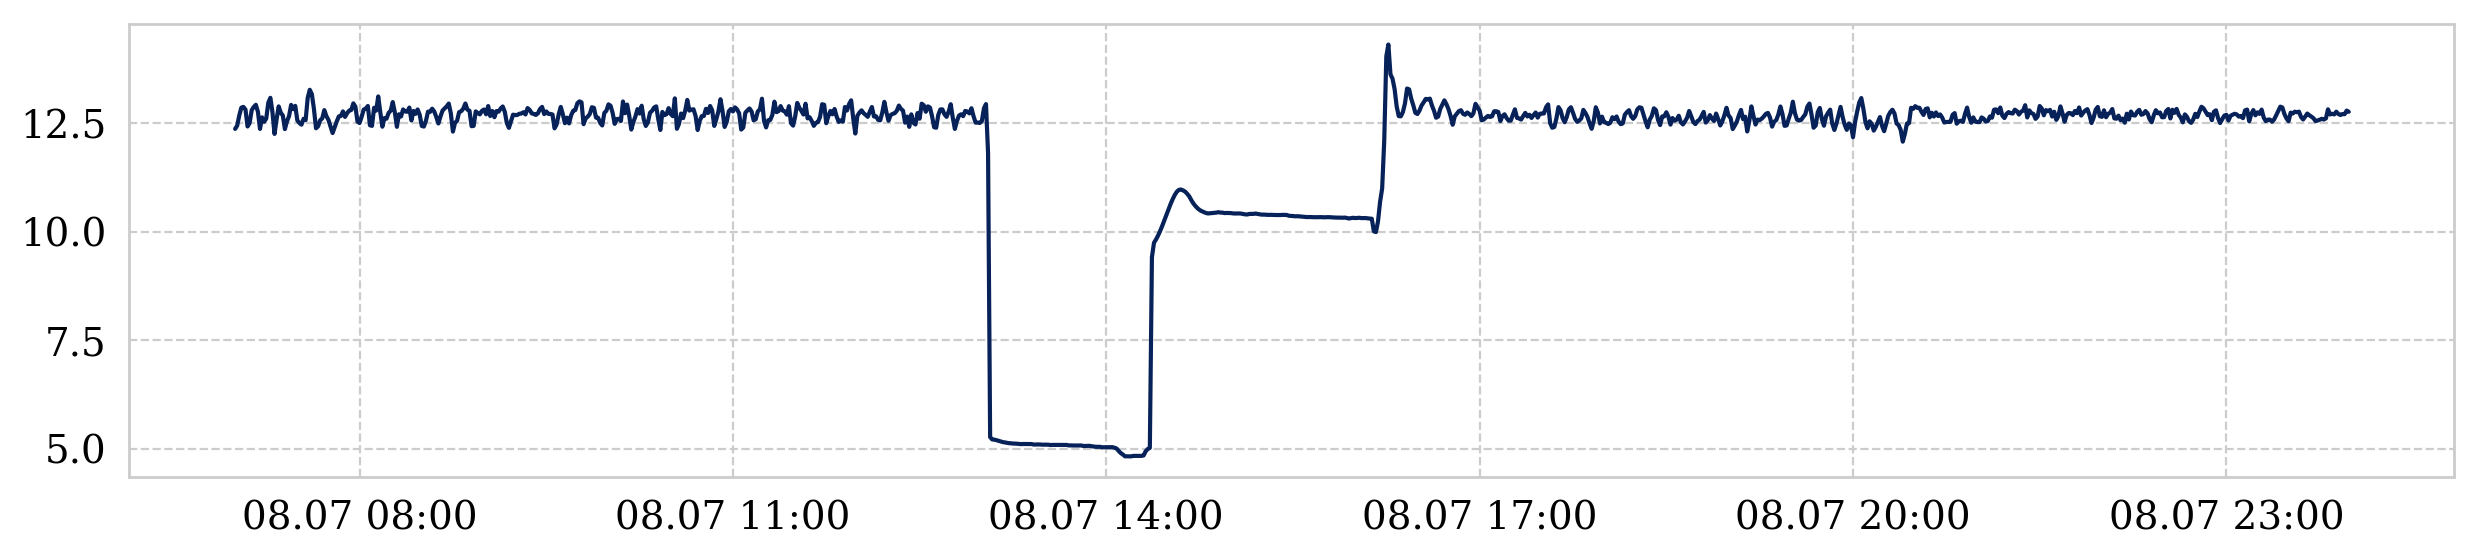

In [19]:
# plot July
def x_fmt(ax):
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m %H:%M'))

plot_dataset(df_july, datetime(2018,7,8,6), datetime(2018,7,10,6), 
             signal=2, x_fmt=x_fmt, y_fmt=None, delta=1)

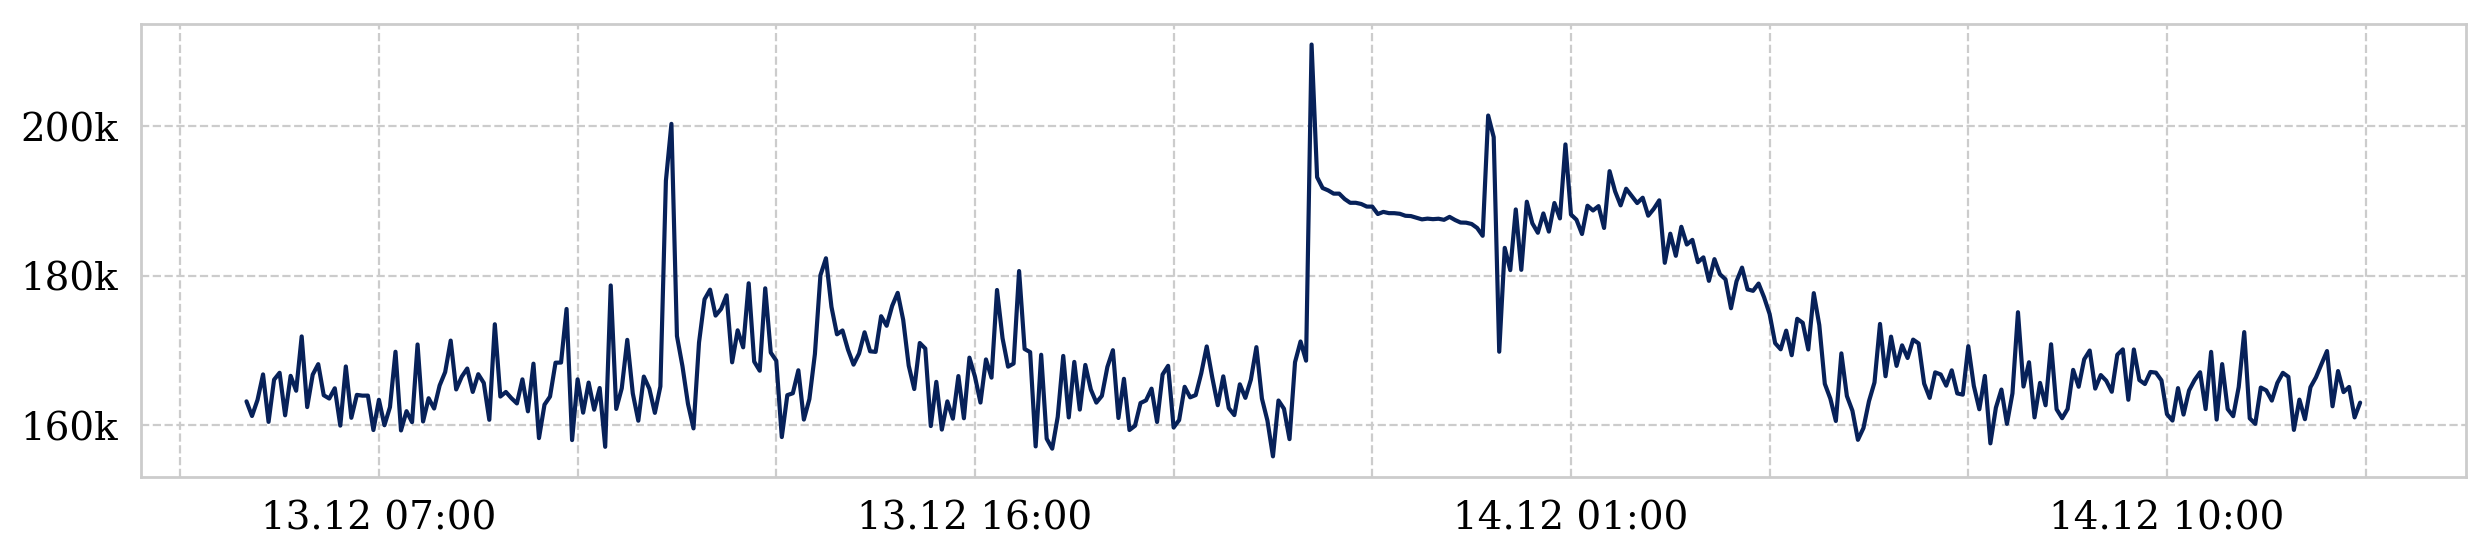

In [20]:
# Plot December
def x_fmt(ax):
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m %H:%M'))

def y_fmt(ax):
    # yticks
    ylabels = [str(int(i//1000)) + "k" for i in ax.get_yticks()]
    ax.set_yticklabels(ylabels)
    #[label.set_visible(False) for label in ax.get_yticklabels()[1::2]]
    
    # xticks
    [label.set_visible(False) for label in ax.get_xticklabels()]
    [label.set_visible(True) for label in ax.get_xticklabels()[1::3]]
    

plot_dataset(df_dec, datetime(2018,12,13), datetime(2018,12,15), 
             signal=0, x_fmt=x_fmt, y_fmt=y_fmt, delta=5)

## [2] Load predictive model and predict on selected data

In [21]:
# Load models
lstm = keras.models.load_model(ROOT_PATH + "models/ensemble/lstm_model.h5")
mlp = keras.models.load_model(ROOT_PATH + "models/ensemble/mlp_model.h5")
lm = f.load_pickle(ROOT_PATH + "models/ensemble/linear_model.pkl")

def predict(X, y, n_pred):
    preds, unc = dlf.predict_with_ensemble(lm, lstm, mlp, X, y, n_pred=n_pred)
    return preds, unc

---
## [3] Method I: Residual based anomaly detection
This method calculates the residuals between the observed and the predicted output values for the compressor, and identifies anomalies based on a comparison between the residual and a predefined residual distribution built on the validation set. The procedure of this method to classify anomalies is illustrated by the schematic below, and can be described by the following steps: 

1. Build the static residual distribution. 
    1. The network predicts for all $V$ observations in the validation set
    2. Calculate the residuals for each observation, $y_v - \hat y_v$ for $v=[0,...,V]$.
    3. Smooth the sequence of residuals, where the last $k$ residuals are averaged
    4. Model the smoothed residuals as a Gaussian distribution, and estimate the parameters using Maximum Likelihood estimation
2. For a new observation; make a prediction, $\hat y$ and calculate the residual $\hat y - y$. 
3. Smooth the residual by taking the average of the $k$ past residuals. 
4. Calculate the tail probability that the smoothed residual comes from the residual distribution
5. Convert the tail probability to a log anomaly likelihood, which defines the _anomaly score_
6. Compare the anomaly score to a threshold, where anomalies are warned for if the anomaly score exceeds the the threshold. 
    
<img src="../fig/anomaly-method1.png" alt="method1-schematic" width="60%"/>

<center><i>Schematic for residual based anomaly detection</i></center>

### Step 1: Building the residual distribution

We build the residual distribution on the residuals of the predictive model when predicting on the validation data. We first load the validation set, then predict with the model on the dataset, with which we calculate a sequence of smoothed residuals. The distribution is modeled as a Gaussian distribution, and we find the parameters using maximum likelihood estimation.  

In [22]:
# load validation set
df_valid = f.load_data()[1]
x_valid, y_valid = f.split_dataset(df_valid.values, delay=1)

# predict with model
preds_valid, unc_valid = predict(x_valid, y_valid,n_pred=50)

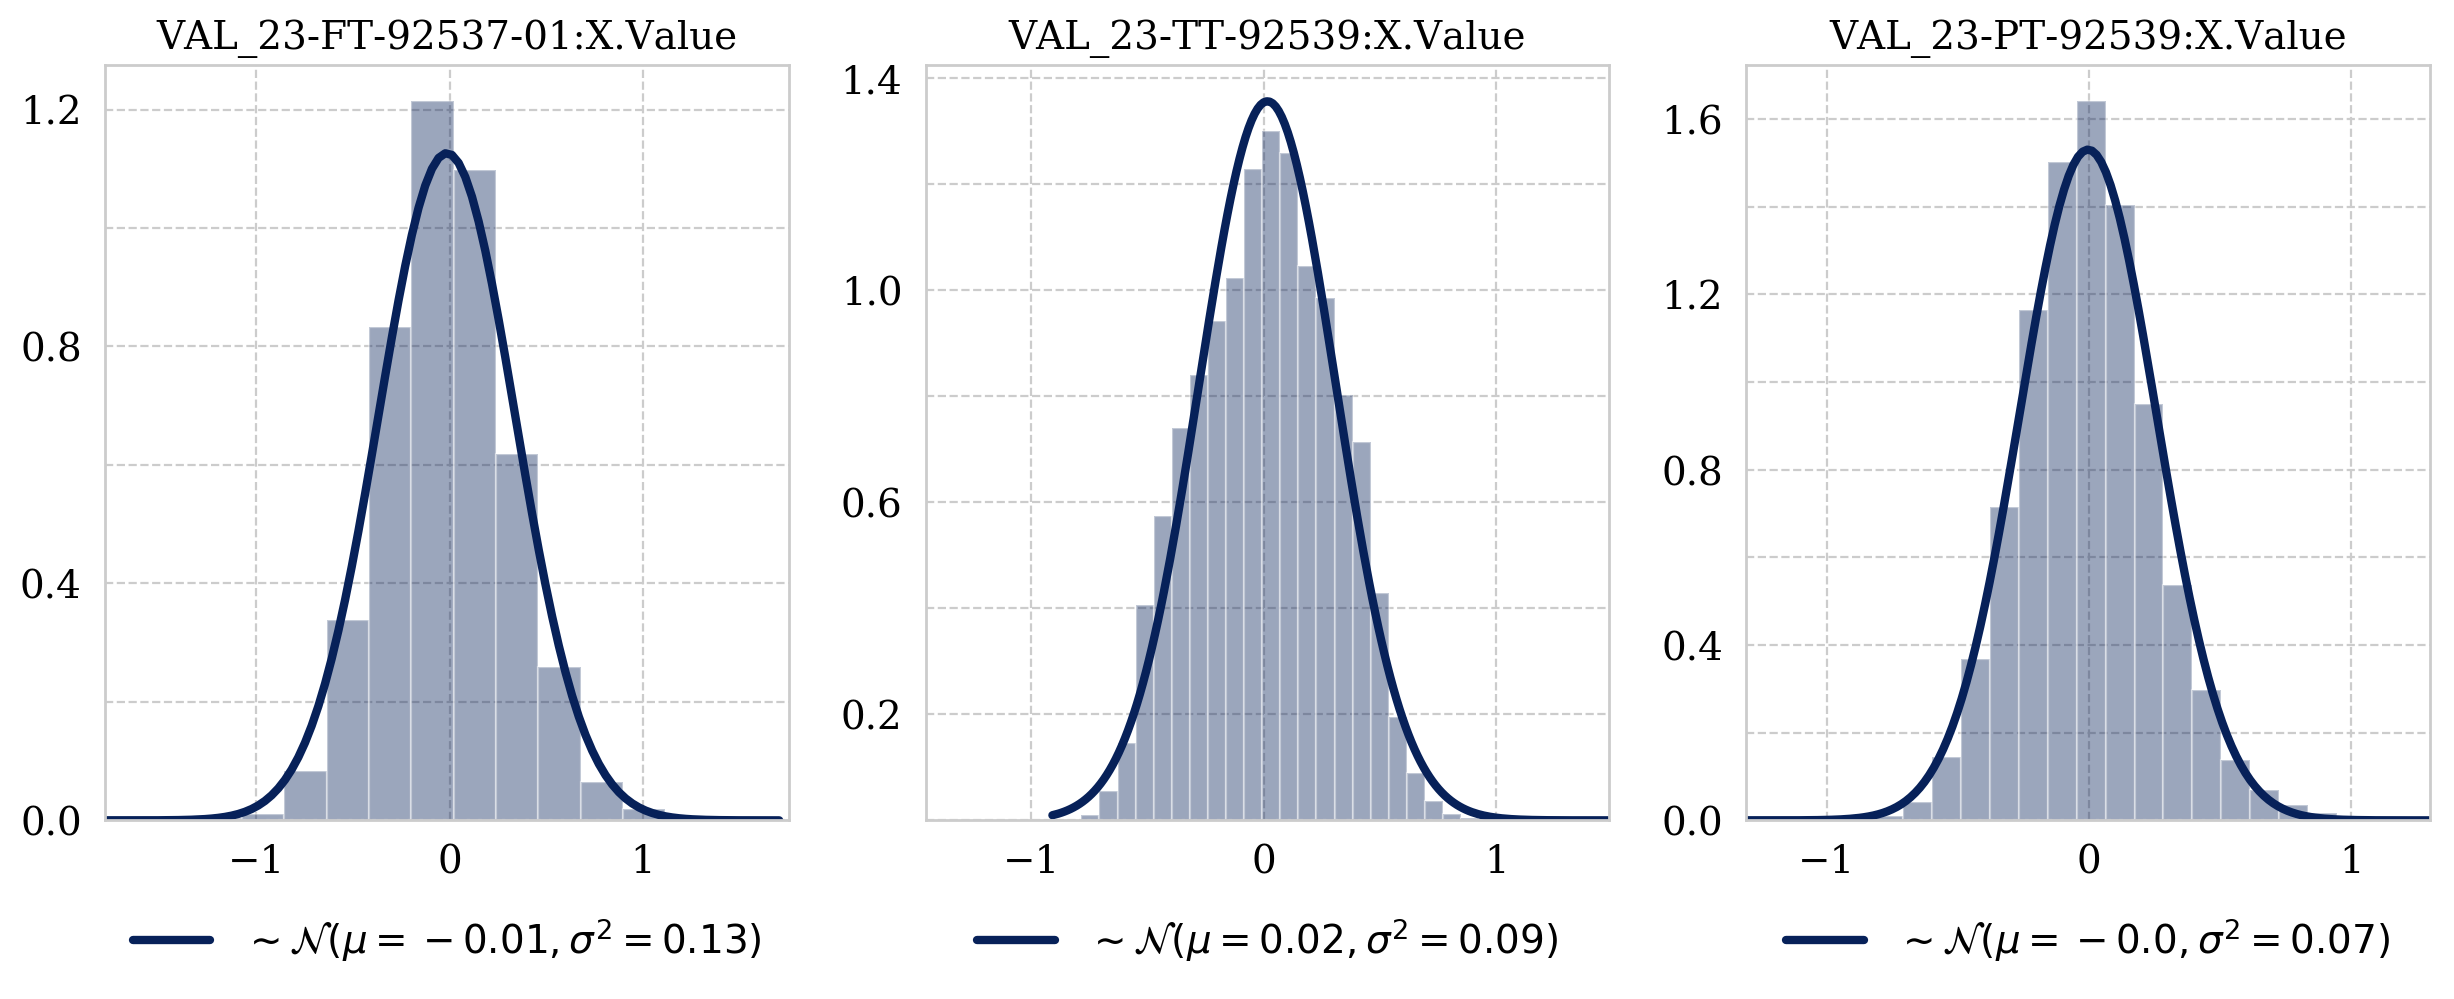

In [23]:
# build residual distributions
def build_residual_distribution(preds_valid, true_valid, smooth=False, smooth_param=5):
    residuals = preds_valid - true_valid
    if smooth: 
        s_residuals = [pd.Series(residuals[:,signal]).rolling(window=smooth_param).mean().iloc[smooth_param-1:].values for signal in range(3)]
        s_residuals = np.array(s_residuals).T
        dist_params = [scstats.norm.fit(s_residuals[:,signal]) for signal in range(s_residuals.shape[-1])]
        
        return dist_params, s_residuals
    else: 
        dist_params=[scstats.norm.fit(residuals[:,signal]) for signal in range(residuals.shape[-1])]
        
        return dist_params, residuals
    
dist_params, residuals = build_residual_distribution(preds_valid, y_valid, True, 5)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
for i, ax in enumerate(axs):
    dist_mean, dist_std = dist_params[i]
    sns.distplot(residuals[:,i], 
                 ax=ax, 
                 fit=scstats.norm, 
                 kde=False,
                 fit_kws={"lw":3, 
                          "color":c["blue_dark"], 
                          "label":r'$ \sim {0}(\mu={1}, \sigma^2={2})$'.format("\mathcal{N}", 
                                                                    round(dist_mean,2), 
                                                                    round(dist_std**2,2))},
                 bins=30
                )
    ax.set_xlim((dist_mean-5*dist_std, dist_mean + 5*dist_std))
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
          ncol=3, fancybox=False, shadow=False, frameon=False)
    ax.set_title(target_tags[i])
    [label.set_visible(False) for label in ax.get_yticklabels()[::-2]]

fig.show()

How do these conform to normality tests? We now perform a Shapiro test and plot the Quantile-Quantile plot (QQ plot) for each of the targets to check this. 

/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


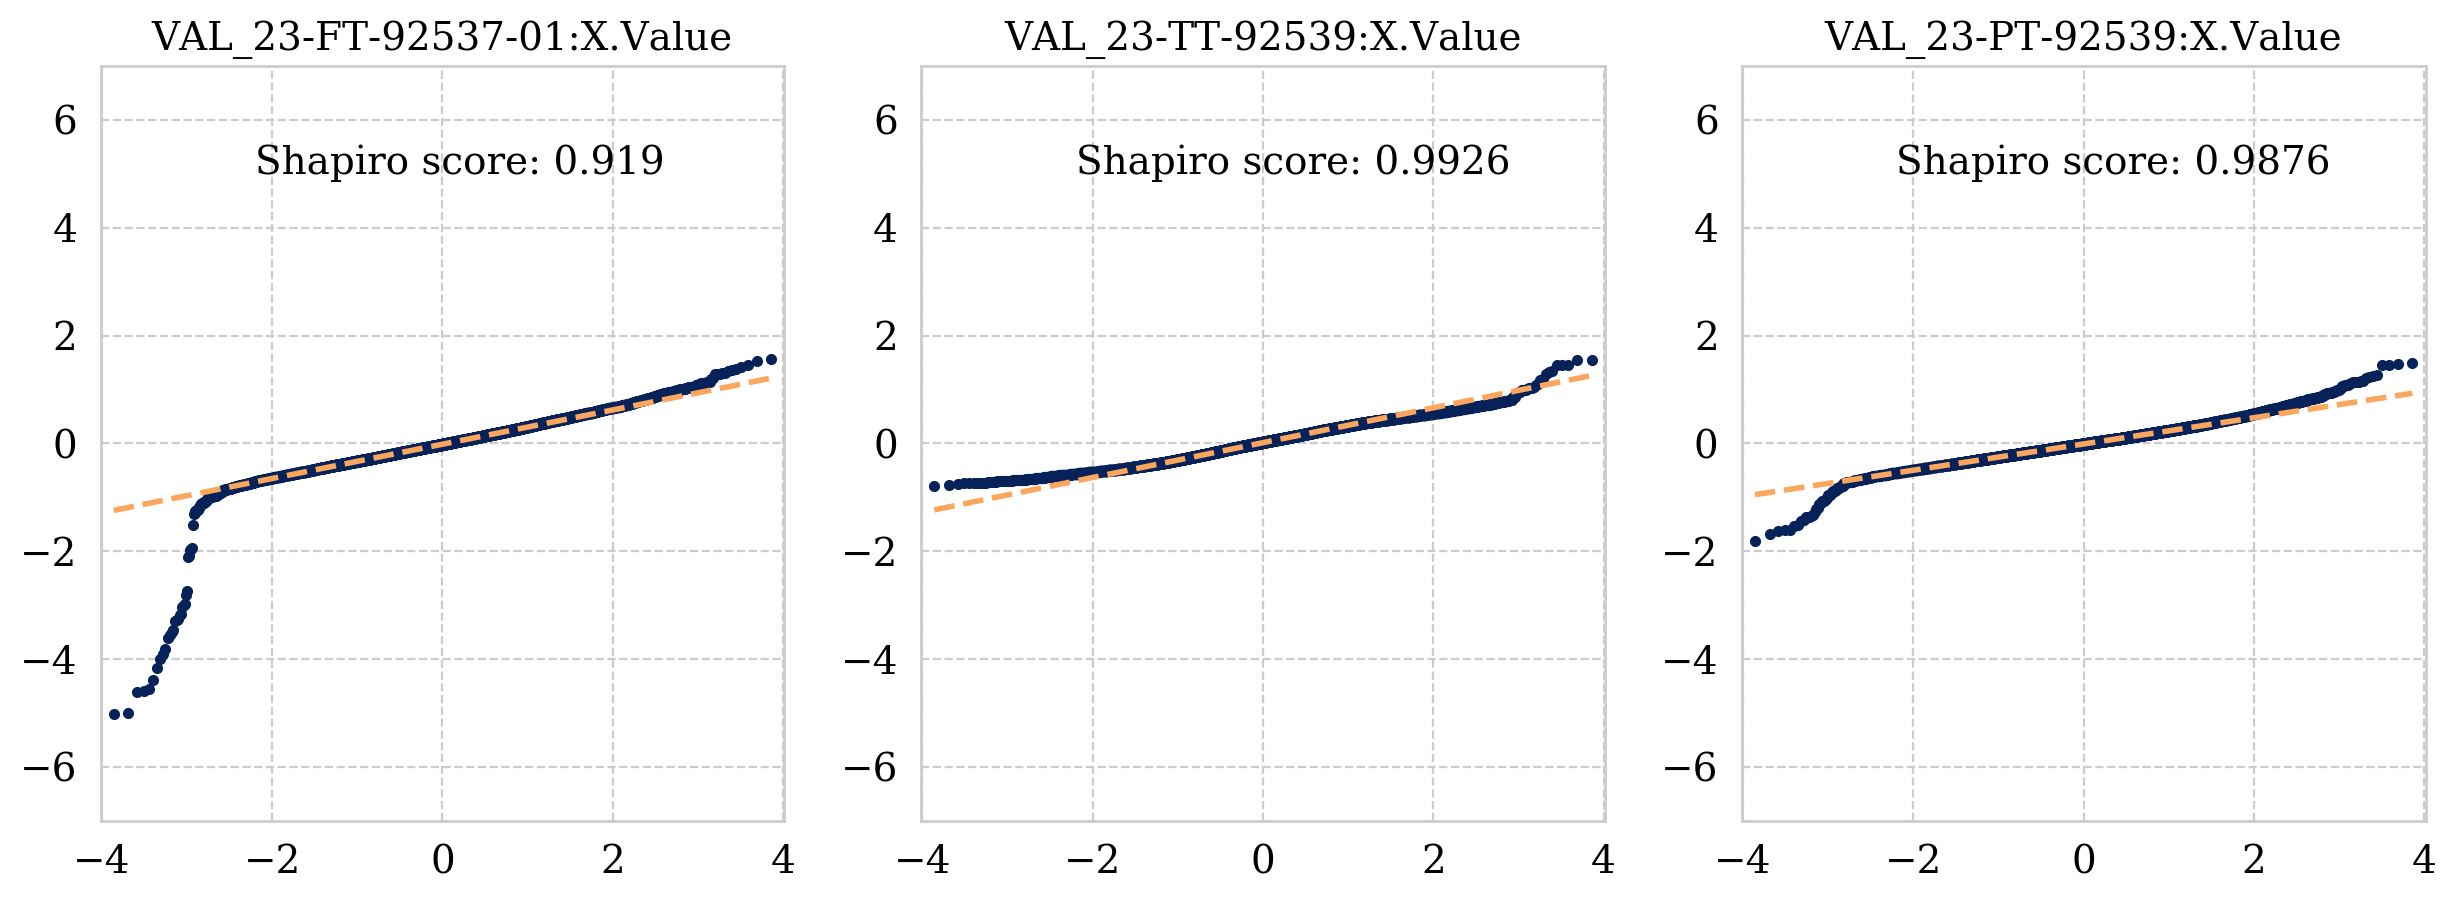

In [24]:
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro

fig, axs = plt.subplots(1,3,figsize=(15,5)) 
for i, ax in enumerate(axs):
    p = qqplot(residuals[:,i], line='q', ax=ax, c=c["blue_dark"])
    dots = fig.findobj(lambda x: hasattr(x, 'get_color') and x.get_color() == 'r')
    [d.set_linestyle('--') for d in dots]
    [d.set_color(c["orange_light"]) for d in dots]
    [d.set_linewidth(2) for d in dots]
    
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_ylim(-7,7)
    
    ax.text(-2.2,5, "Shapiro score: " + str(round(shapiro(residuals[:,i])[0], 4)), fontsize=14)
    ax.set_title(target_tags[i])

fig.show()
    

The results display that the Gaussian distribution assumption is roughly valid. Further discussion in the thesis. 

### Step 2: Define logic to classify anomalies

In [25]:
def tail_probability(x, mu, sigma):
    """
    Defines the probability that a observation x belongs to the Gaussian distribution with parameters
    mean=mu and std=sigma, i.e. the area under the distribution at x. 
    """
    z = (x - mu) / sigma
    return 1.0 - 0.5 * math.erfc(z / np.sqrt(2))


def calculate_anomaly_likelihood(residual, distr_mu, distr_std):
    """
    Calculates the log anomaly likelihood that a residual comes from a Gaussian distribution with 
    a specified mean and standard deviance.
    
    Args:
        new_residual (float): A new residual to classify
        past_residuals ([float]): Sequence of N past residuals
        distr_mu (float): The mean of the residual distribution
        distr_std (float): The standard deviance of the residual distribution
        smooth_param: Maximum number of observations to use for a smoothed residual
    
    Returns: 
        the log anomaly likelihood
    """
    
    # calculate the tail probability that the smoothed residual comes from the residual distribution
    tail_prob = tail_probability(residual, distr_mu, distr_std)
    
    # convert the tail probability to an anomaly score and finally, the log likelihood
    anomaly_score = abs(0.5 - tail_prob)    
    log_likelihood = np.log(1 + 1e-10 - 2 * anomaly_score) / np.log(1e-10)

    return log_likelihood

def get_anomaly_likelihoods(residuals, dist_params, smooth_param=5):
    """
    Calculates anomaly likelihoods for an array of smoothed residuals. 
    
    Args:
        residuals (np.ndarray): array of residuals
        dist_params [(float, float)]: tuples of distribution parameters [(mean, std)]
        smooth_param (int): number of past residuals to use for smoothing
    
    Returns: 
        np.ndarray: array of anomaly likelihoods
    """
    
    # smooth the residuals
    ## take the N past residuals and average them
    smoothed_residuals=np.array([np.mean(residuals[i-smooth_param:i+1],axis=0) 
                                 for i in range(smooth_param,len(residuals))])
    
    # calculate anomaly likelihoods
    anomaly_likelihoods = [np.zeros(len(residuals)) for i in range(3)]
    for signal in range(3):
        mu, std = dist_params[signal]
        signal_residuals = smoothed_residuals[:,signal]
        
        for i, res in enumerate(signal_residuals):
            anomaly_likelihoods[signal][i+smooth_param] = calculate_anomaly_likelihood(res, mu, std)
    
    return np.array(anomaly_likelihoods).T

def get_residual_based_anomalies(df, signal, threshold, dist_params, n_pred, smooth_param, scaling_stats):
    """
    Makes predictions for a dataframe. Will first split the dataset into features and targets and predict
    values for these. Then, the residuals are calculated, which are used to evaluate the anomaly scores.
    
    Args: 
        df (pd.DataFrame): the dataframe on which to predict 
        signal (int): which target to extract 
        threshold (float): the threshold which defines an anomaly score as anomalous
        n_pred (int): the number of predictions made by the model
        smooth_param (int): number of past residuals to use for smoothing
        scaling_stats (pd.DataFrame): dataframe with scaling means and standard deviances
    
    returns: 
        pd.DataFrame: dataframe with targets, predictions, scores, and anomaly classification
    """
    
    # split dataset into features and target
    X, y = f.split_dataset(df.values, delay=1)
    
    # make predictions and calculate residuals
    preds, unc = predict(X, y, n_pred=n_pred)
    residuals = preds - y
    
    # calculate anomaly scores
    anomaly_scores = get_anomaly_likelihoods(residuals, dist_params, smooth_param)
    bol_anomalies = anomaly_scores[:,signal] > threshold
    
    # combine results in a dataframe
    std = scaling_stats["Std"][signal]
    mean = scaling_stats["Mean"][signal]
    anom_df = pd.DataFrame({"true": y[:,signal]*std + mean,
                            "pred": preds[:,signal]*std + mean,
                            "score": anomaly_scores[:,signal],
                            "anomaly": bol_anomalies},
                            index=df.index[1:])
    
    return anom_df

def plot_residual_anomalies(anomaly_df, threshold, delta=1, 
                            from_date=None, to_date=None, 
                            date_fmt=None, x_fmt=None, y_fmt=None):
    """
    Plots an predictions, true targets, anomaly scores and corresponding anomaly regions.
    """
    
    plt.figure(figsize=(15,5))
    gs = gridspec.GridSpec(3,1)
    

    # ------ TOP PLOT ------ #
    # plot predictions, true measurements
    ax = plt.subplot(gs[:2,:])
    
    def std_date_fmt(ax):
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m %H'))
        
    date_fmt(ax) if date_fmt else std_date_fmt(ax)
        
    if from_date not in anomaly_df.index:
        from_date = anomaly_df.index[0]
    if to_date not in anomaly_df.index:
        to_date = anomaly_df.index[-1]
    
    # plot predictions vs targets
    ax.plot(anomaly_df["pred"][from_date:to_date:delta], c=c["red"], label="predicted")
    ax.plot(anomaly_df["true"][from_date:to_date:delta], c=c["blue_med"], label="actual")
    
    # plot anomalous regions
    for anomaly in anom_df[from_date:to_date][anom_df["anomaly"] == True].index:
        ax.axvspan(anomaly, anomaly, alpha=0.4, color="pink", lw=8)
    
    ax.legend()
    ax.set_xticklabels([])
    
    # format x and y axes
    if y_fmt: y_fmt(ax)
    if x_fmt: x_fmt(ax)


    # ----- BOTTOM PLOT ----- #
    # plot the anomaly scores
    ax = plt.subplot(gs[2, :])
    
    date_fmt(ax) if date_fmt else std_date_fmt(ax)
        
    ax.plot(anomaly_df["score"][from_date:to_date:delta])
    ax.axhline(y=threshold, c=c["gray"], linestyle='--')
    
    # format x and y axes
    ax.set_ylim(0, 1.05)
    if x_fmt: x_fmt(ax)

    plt.show()

### Step 3: Demonstration of method I

In [28]:
N_PRED = 50
SMOOTH_PARAM = 5

#### April 2018

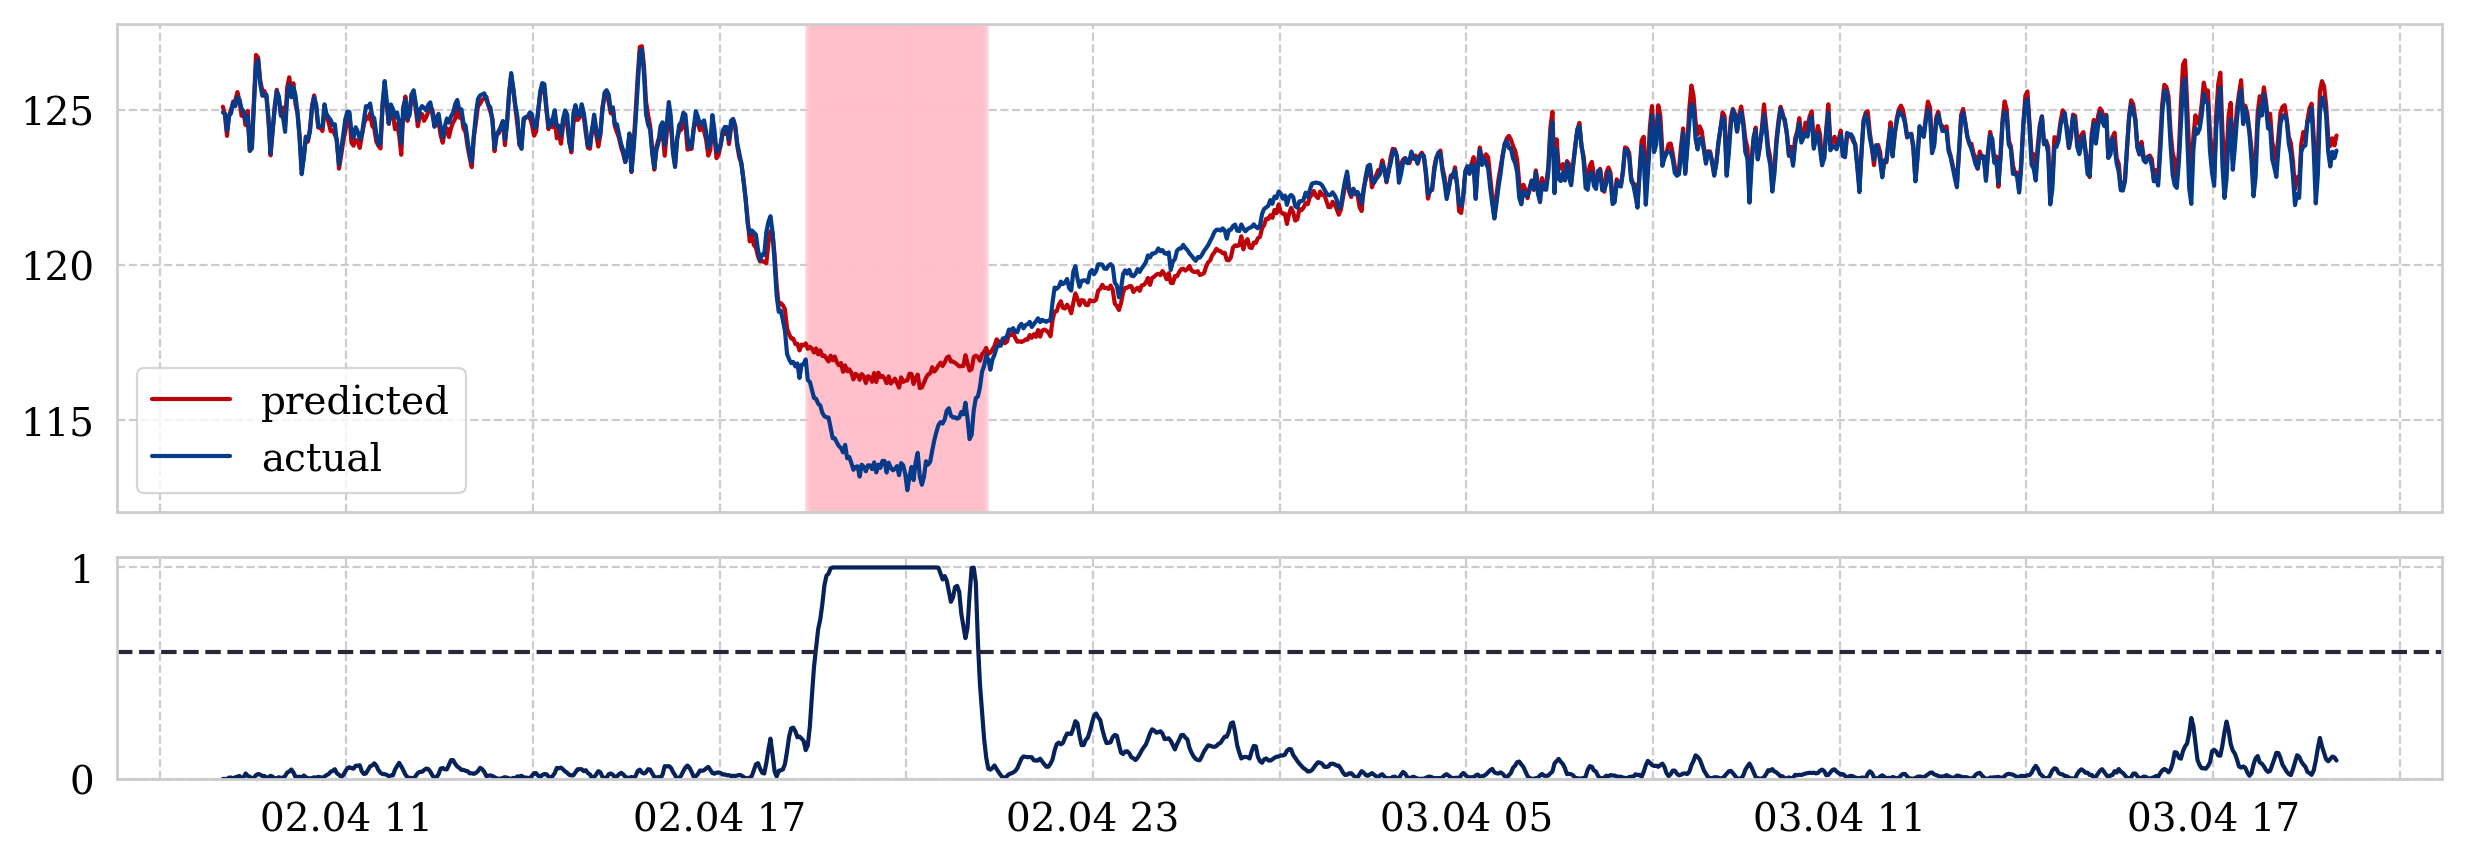

In [29]:
signal, threshold = 1, 0.6
anom_df = get_residual_based_anomalies(df=df_april, 
                                       signal=signal, 
                                       threshold=threshold, 
                                       dist_params=dist_params, 
                                       n_pred=N_PRED, 
                                       smooth_param=SMOOTH_PARAM, 
                                       scaling_stats=dp.scaling_stats)
def date_fmt(ax): 
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m %H'))

def x_fmt(ax):
    [label.set_visible(False) for label in ax.get_xticklabels()[::2]]

plot_residual_anomalies(anom_df, threshold=threshold, delta=2, 
                        date_fmt=date_fmt, x_fmt=x_fmt, y_fmt=None)

#### July 2018

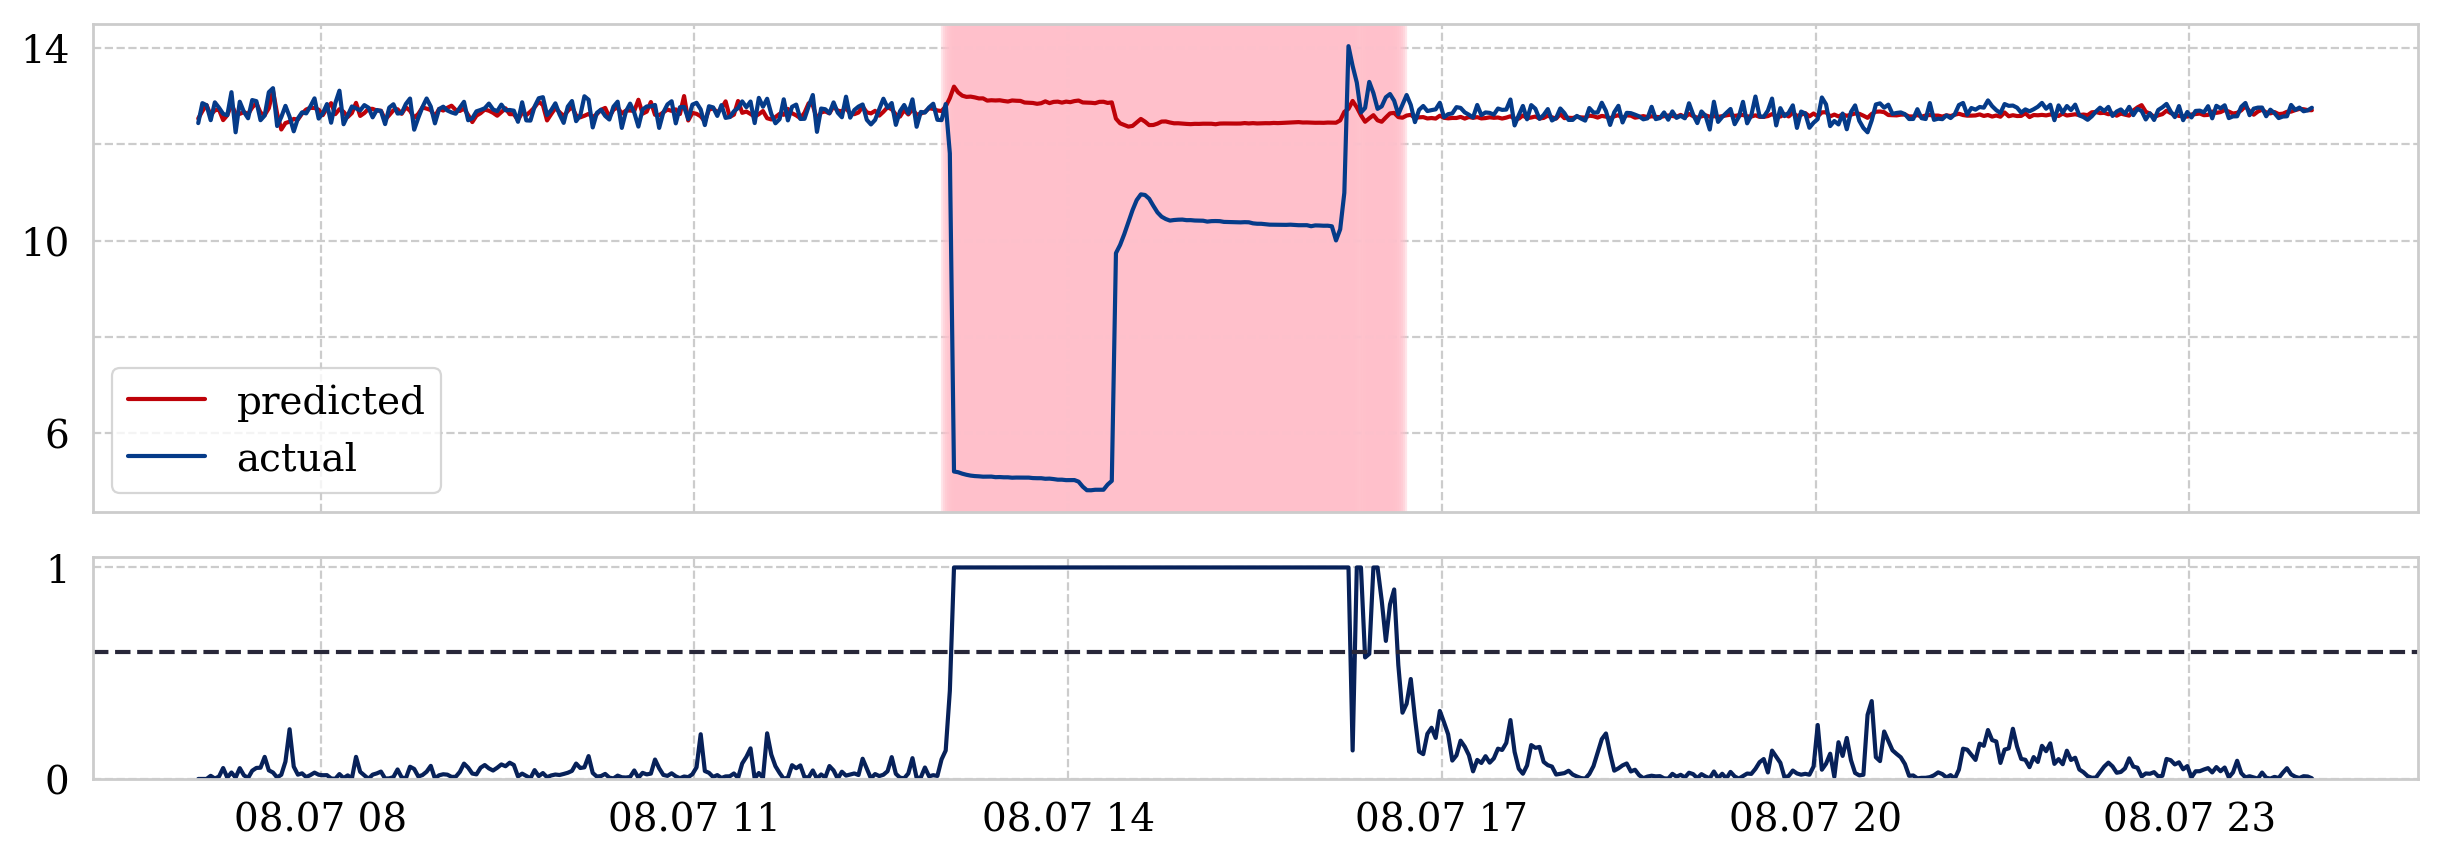

In [30]:
signal, threshold = 2, 0.6
anom_df = get_residual_based_anomalies(df=df_july, 
                                       signal=signal, 
                                       threshold=threshold, 
                                       dist_params=dist_params, 
                                       n_pred=N_PRED, 
                                       smooth_param=SMOOTH_PARAM, 
                                       scaling_stats=dp.scaling_stats)

def y_fmt(ax):
    [label.set_visible(False) for label in ax.get_yticklabels()[::2]]

plot_residual_anomalies(anom_df, threshold=threshold, delta=2, 
                        date_fmt=date_fmt, x_fmt=None, y_fmt=y_fmt)

#### December 2018

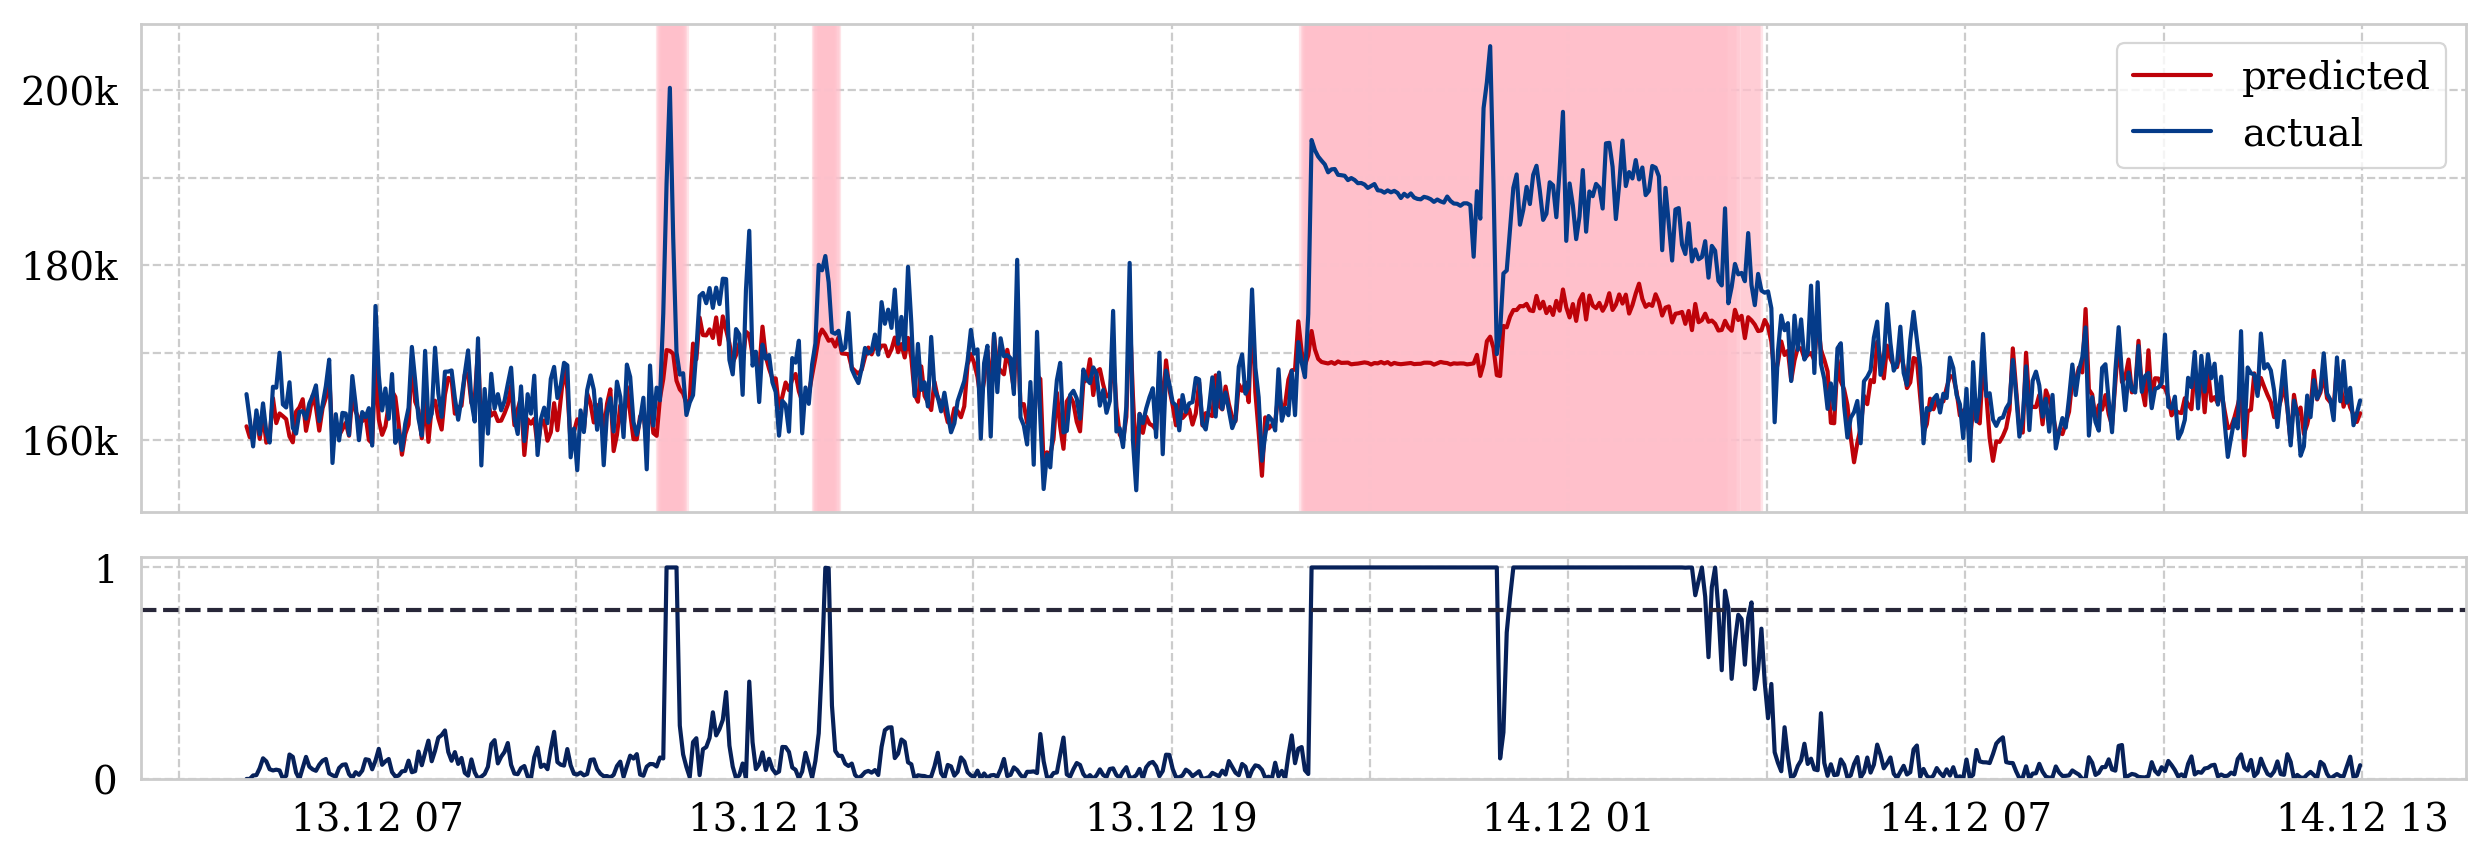

In [31]:
signal, threshold = 0, 0.8
anom_df = get_residual_based_anomalies(df=df_dec, 
                                       signal=signal, 
                                       threshold=threshold, 
                                       dist_params=dist_params, 
                                       n_pred=N_PRED, 
                                       smooth_param=SMOOTH_PARAM, 
                                       scaling_stats=dp.scaling_stats)
def x_fmt(ax): 
    [label.set_visible(False) for label in ax.get_xticklabels()[::2]]

def y_fmt(ax):
    ylabels = [str(int(i//1000)) + "k" 
               if i > 1000 else str(i) 
               for i in ax.get_yticks()]
    
    ax.set_yticklabels(ylabels)
    [label.set_visible(False) for label in ax.get_yticklabels()[::2]]
    
plot_residual_anomalies(anom_df, threshold=threshold, delta=3, 
                        date_fmt=date_fmt, x_fmt=x_fmt, y_fmt=y_fmt)

## [4] Method II: Prediction interval based anomaly detection

This approach exploits the fact that the predictive models are probabilistic, and utilizes the point- wise predictive distributions of the models to identify anomalies. A new observation is classified based on whether it is within the bounds of the prediction interval of the model. The networks implemented, including the LSTM/MLP ensemble model utilized in this notebook, are stochastic models where the predictions are samples drawn from the point-wise predictive distribution. We have implemented methods to assess the predictive distributions of the network. For any input, we are interested in the predictive mean, $\hat y^{*}$, and the total uncertainty regarding this prediction, $\eta$. The uncertainty is the standard deviance of the prediction, and is a number that combines the _aleatoric_ and _epistemic_ uncertainty. Consequently, we can compute the upper and lower bounds of the prediction intervals for a prediction $\hat y^{*}$ by $\hat y^* \pm \eta \cdot z_{\alpha / 2}$, where $z_{\alpha / 2}$ is the upper $\alpha/2$ quantile of the standard normal. Here we set $z=2.33$, which corresponds to a $99\%$ confidence interval. 

As shown in the schematic below, this method goes as follows to classify a new input $X$ and true observation $y$:
1. The network makes N predictions for the input, and the predictive mean ($\hat y$) and uncertainty ($\eta$) is estimated empirically. 
2. The upper and lower confidence levels are calculated. We set $z=2.33$, which corresponds to a $99\%$ confidence interval. 
3. The true target ($y$) is compared to the confidence interval, and the observation is marked as a point-anomaly if $y < \hat y^ - \eta \cdot z_{\alpha / 2}$ or $y > \hat y^ + \eta \cdot z_{\alpha / 2}$. 
4. As true anomalies rarely happen alone, we are more interested in collective anomalies. We therefore only mark an observation as anomalous if the past $k$ observations are point anomalies.

<img src="../fig/anomaly-method2.png" alt="method2-schematic" width="60%"/>

<center><i>Schematic for PI based anomaly detection</i></center>

### Step 1: Define logic to classify anomalies

In [32]:
def get_pi_based_anomalies(df, signal, n_pred, smooth_param, scaling_stats, z=2.33):
    # split dataset into features and target
    X, y = f.split_dataset(df.values, delay=1)
    
    # make predictions
    preds, unc = predict(X, y, n_pred=n_pred)
    
    # calculate lower and upper bounds of confidence interval
    lower_pi, upper_pi = preds - z*unc, preds + z*unc
    
    # classify anomalies
    true, low, up = y[:,signal], lower_pi[:,signal], upper_pi[:,signal]
    point_anomalies = np.array([true[i] > up[i] or true[i] < low[i] for i in range(len(y))])
    collective_anomalies = [False for i in range(len(point_anomalies))]
    for i in range(len(point_anomalies)): 
        if i < smooth_param: 
            collective_anomalies[i] = False
            continue
        
        tmp_anomalies = point_anomalies[i-smooth_param:i+1]
        if np.any(tmp_anomalies == False): 
            continue
        collective_anomalies[i] = True
    
    # make dataframes
    std = scaling_stats.loc[:,"Std"][signal]
    mean = scaling_stats.loc[:,"Mean"][signal]
    
    # make dataframe 
    anomaly_dict = {"true": y[:,signal]*std + mean,
                    "pred": preds[:,signal]*std + mean,
                    "uncertainty": unc[:,signal]*std,
                    "lower_pi": lower_pi[:,signal]*std + mean,
                    "upper_pi": upper_pi[:,signal]*std + mean,
                    "anomaly": collective_anomalies
                   }
    
    anom_df = pd.DataFrame(anomaly_dict, index=df.index[1:])
    return anom_df

def plot_pi_anomalies(anomaly_df, delta=1, 
                      from_date=None, to_date=None, 
                      date_fmt=None, x_fmt=None, y_fmt=None):
    """
    Plots an predictions, true targets, confidence intervals and corresponding anomaly regions.
    """
    
    fig, ax = plt.subplots(1,1,figsize=(15,5), dpi=200)

    def std_date_fmt(ax):
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m %H:%M'))
        
    date_fmt(ax) if date_fmt else std_date_fmt(ax)
    
    # get start dates and end dates for plotting
    if from_date not in anomaly_df.index:
        from_date = anomaly_df.index[0]
    if to_date not in anomaly_df.index:
        to_date = anomaly_df.index[-1]
    
    # plot prediction intervals
    lower, upper = anomaly_df["lower_pi"][from_date:to_date], anomaly_df["upper_pi"][from_date:to_date]
    ax.plot(lower[::delta], color = "darkgray", label="")
    ax.plot(upper[::delta], color = "darkgray", label="")
    ax.fill_between(lower[::delta].index, lower[::delta], upper[::delta], color='grey', alpha='0.3')
    
    # plot predictions and actual targets
    ax.plot(anomaly_df["pred"][from_date:to_date:delta], c=c["red"], lw=2, label="predicted")
    ax.plot(anomaly_df["true"][from_date:to_date:delta], c=c["blue_med"], lw=2, label="actual")
    
    # plot anomaly regions 
    for anomaly in anom_df[from_date:to_date][anom_df["anomaly"] == True].index:
        ax.axvspan(anomaly, anomaly, alpha=0.4, color="pink", lw=8)
        
    leg = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                    ncol=2, fancybox=True, shadow=False, frameon=False)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3.0)
        
    # format x and y axes
    if x_fmt: x_fmt(ax) 
    if y_fmt: y_fmt(ax)
    
    fig.show()
    

### Step 2: Demonstration of method II 

In [33]:
N_PRED = 50
SMOOTH_PARAM = 5

#### April 2018

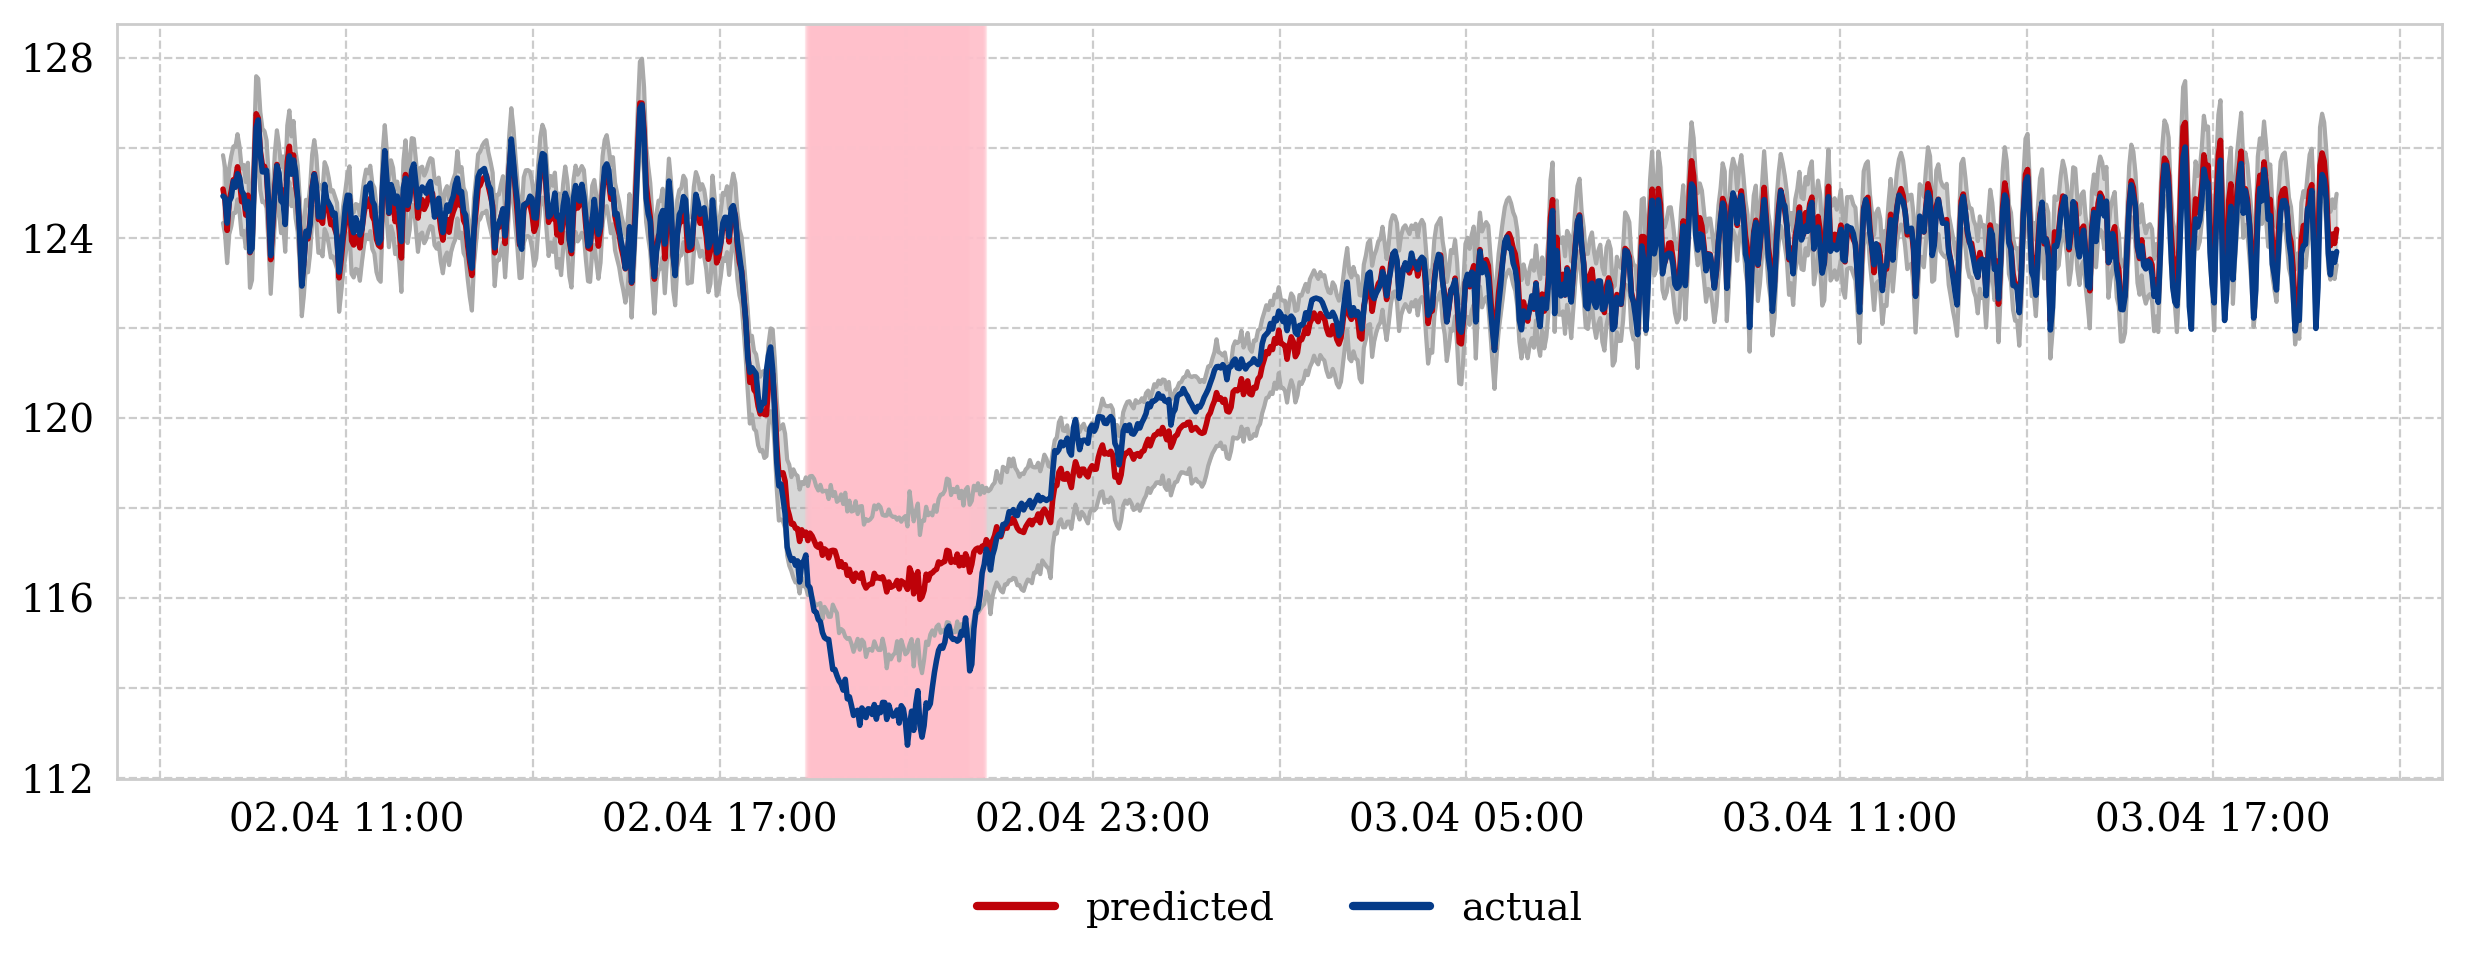

In [34]:
df, signal = df_april, 1
anom_df = get_pi_based_anomalies(df=df, 
                                 signal=signal, 
                                 n_pred=N_PRED, 
                                 smooth_param=SMOOTH_PARAM, 
                                 scaling_stats=dp.scaling_stats)

def x_fmt(ax): 
    [label.set_visible(False) for label in ax.get_xticklabels()[::2]]

def y_fmt(ax):
    [label.set_visible(False) for label in ax.get_yticklabels()[::2]]

plot_pi_anomalies(anom_df, delta=2, x_fmt=x_fmt, y_fmt=y_fmt)

#### July 2018

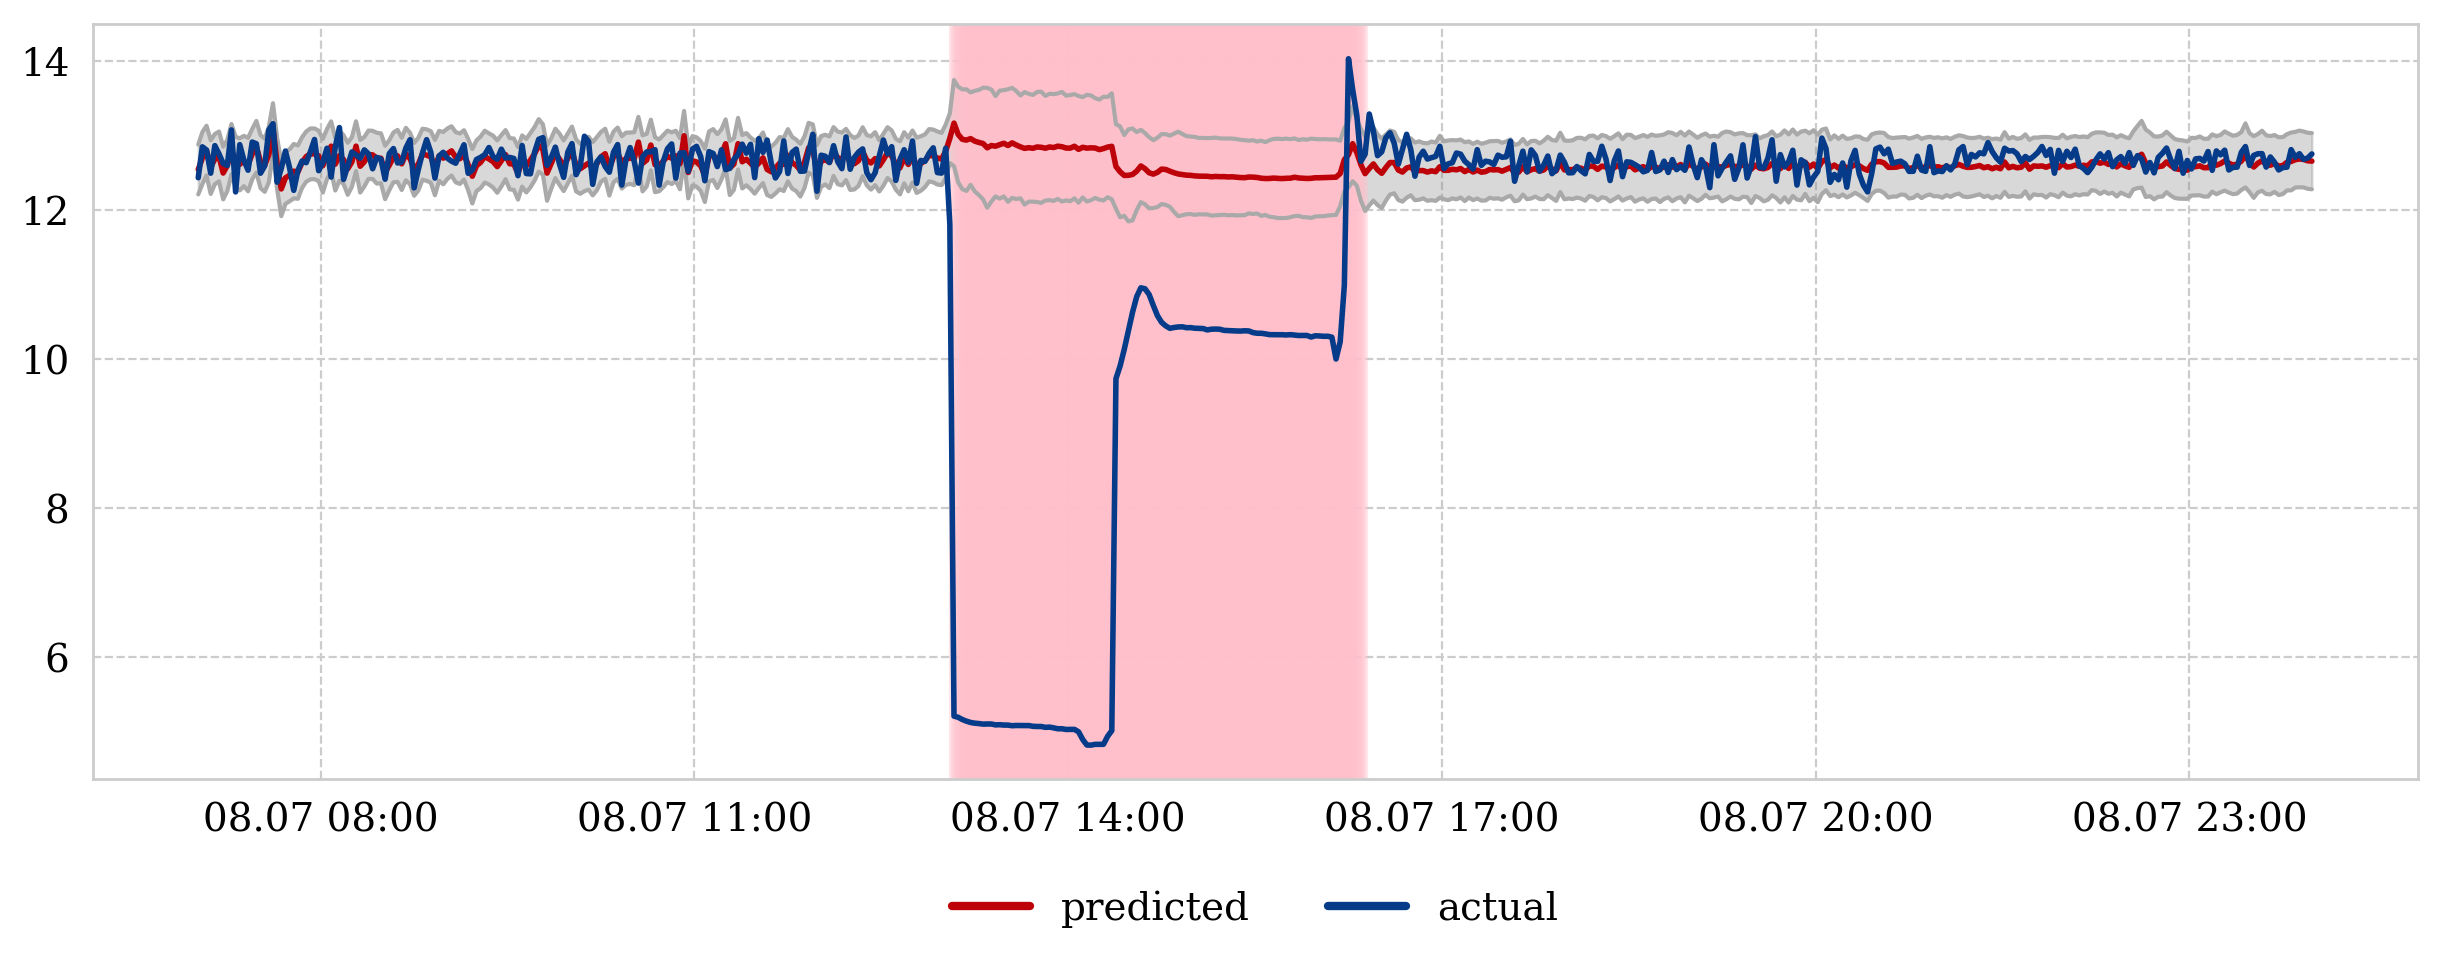

In [35]:
df, signal = df_july, 2
anom_df = get_pi_based_anomalies(df, 
                                 signal=signal, 
                                 n_pred=N_PRED, 
                                 smooth_param=SMOOTH_PARAM, 
                                 scaling_stats=dp.scaling_stats)

def x_fmt(ax): 
    [label.set_visible(False) for label in ax.get_xticklabels()[::2]]

def y_fmt(ax):
    [label.set_visible(False) for label in ax.get_yticklabels()[::2]]

plot_pi_anomalies(anom_df, delta=2, x_fmt=None, y_fmt=None)

#### December 2018

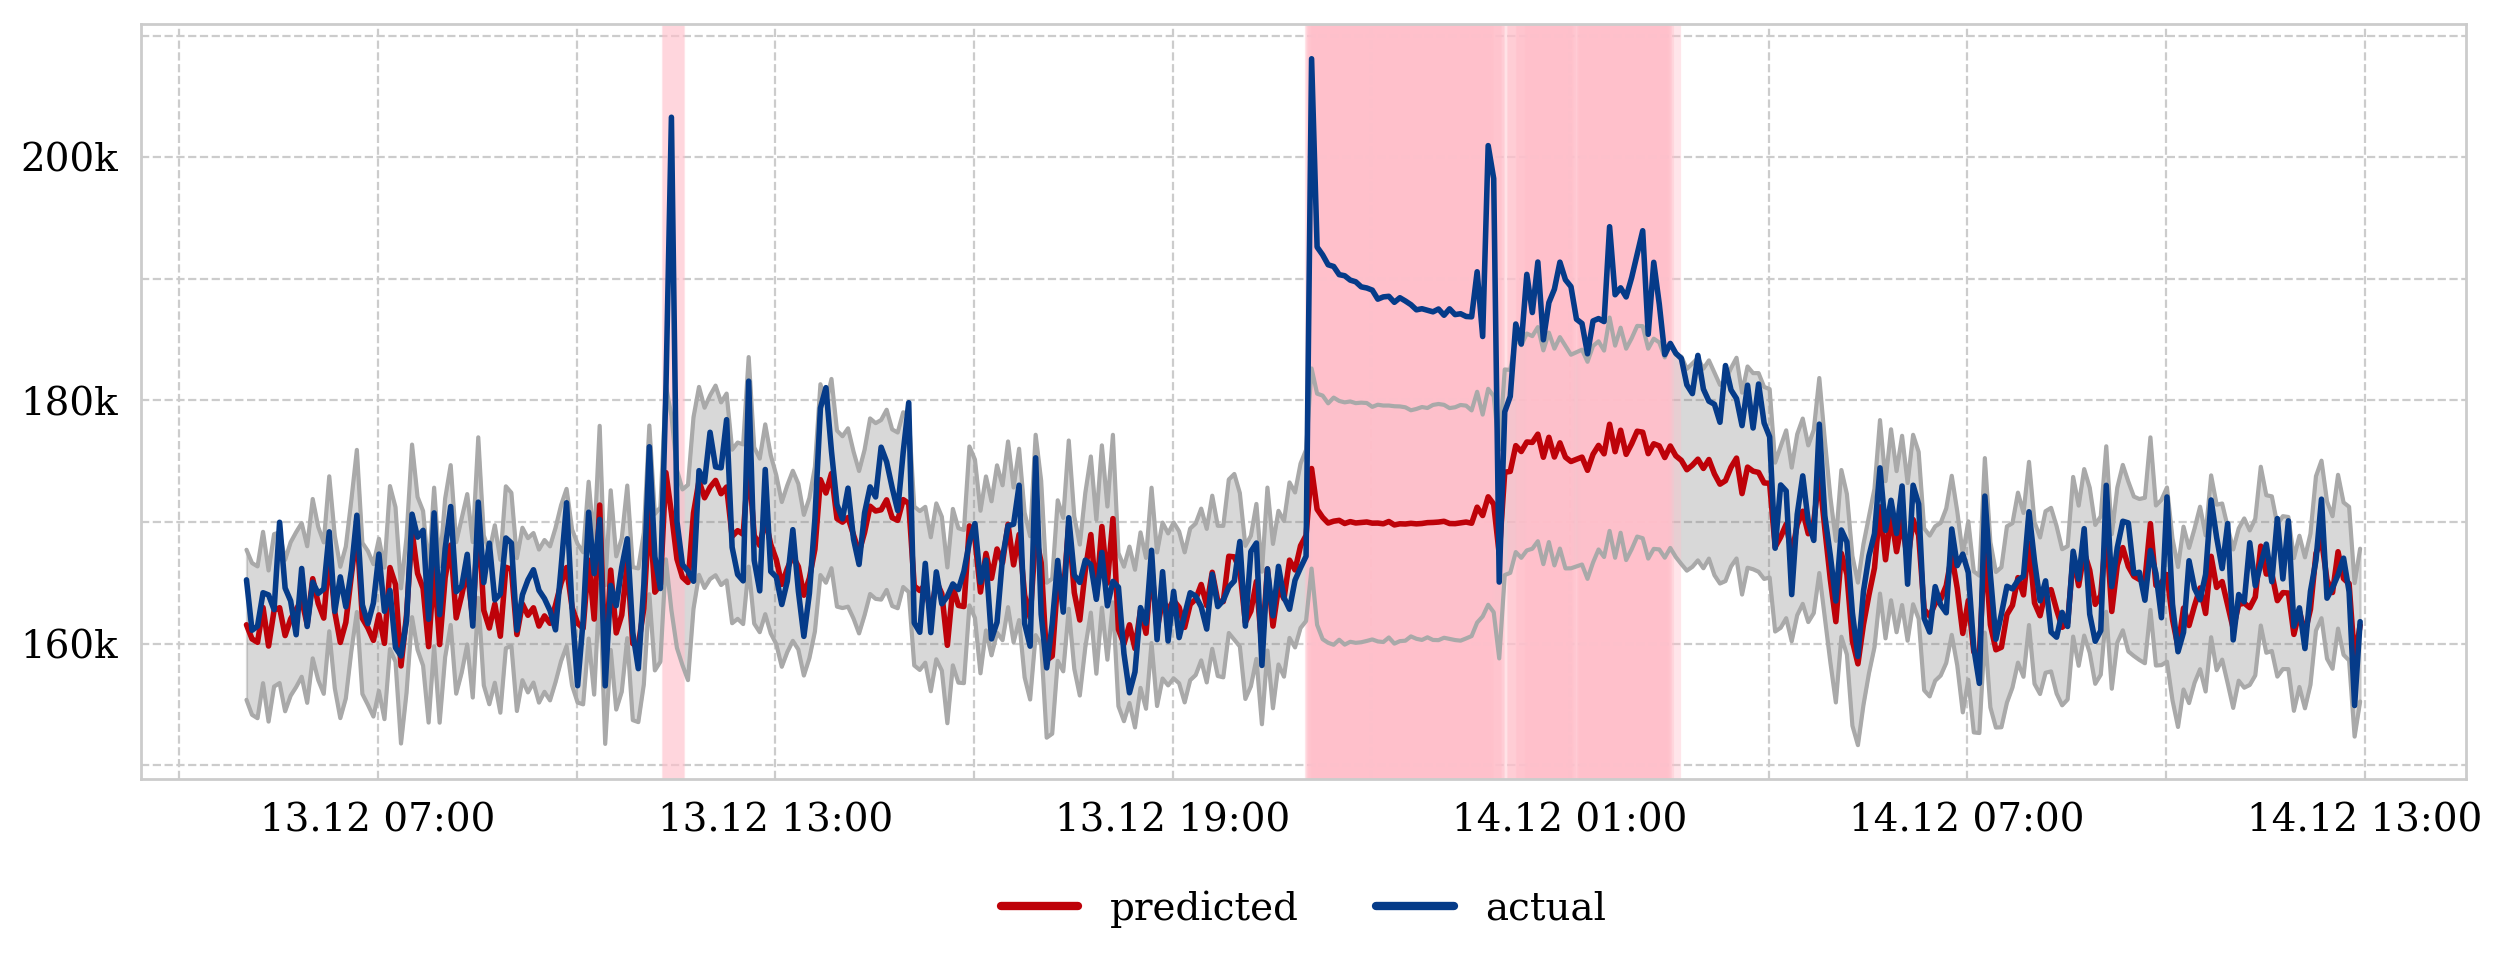

In [36]:
df, signal = df_dec, 0
anom_df = get_pi_based_anomalies(df=df, 
                                 signal=signal, 
                                 n_pred=N_PRED, 
                                 smooth_param=SMOOTH_PARAM, 
                                 scaling_stats=dp.scaling_stats)

def x_fmt(ax): 
    [label.set_visible(False) for label in ax.get_xticklabels()[::2]]

def y_fmt(ax):
    ylabels = [str(int(i//1000)) + "k" 
               if i > 1000 else str(i) 
               for i in ax.get_yticks()]
    
    ax.set_yticklabels(ylabels)
    [label.set_visible(False) for label in ax.get_yticklabels()[1::2]]

plot_pi_anomalies(anom_df, delta=5, x_fmt=x_fmt, y_fmt=y_fmt)